In [11]:
# Google Playstore — Cleaning & Feature Engineering
import pandas as pd
import numpy as np
from datetime import datetime
import os


In [2]:

INPUT = "googleplaystore.csv"                
OUTPUT = "googleplaystore_cleaned.csv"

# 1) Load
df = pd.read_csv(INPUT)
print("Original shape:", df.shape)

# 2) Drop exact duplicates
df = df.drop_duplicates().reset_index(drop=True)

# 3) CATEGORY fix: some rows have garbage; mark them as NaN to inspect later
df['Category'] = df['Category'].apply(lambda x: x if isinstance(x, str) and any(c.isalpha() for c in x) else np.nan)


Original shape: (10841, 13)


In [3]:

# 4) REVIEWS -> numeric (handles '3.0M', '12k', '1,234', etc.)
def reviews_to_num(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip()
        if s.endswith('M'):
            return float(s[:-1]) * 1_000_000
        if s.endswith('k') or s.endswith('K'):
            return float(s[:-1]) * 1_000
        return float(s.replace(',',''))
    except:
        return np.nan

df['Reviews'] = df['Reviews'].apply(reviews_to_num)


In [4]:

# 5) SIZE -> numeric in KB (approx)
def size_to_kb(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip()
        if s.lower() == 'varies with device':
            return np.nan
        if s.endswith('M'):
            return float(s[:-1]) * 1024        # MB -> KB
        if s.endswith('k') or s.endswith('K'):
            return float(s[:-1])              # already KB
        return float(s)
    except:
        return np.nan

df['Size_KB'] = df['Size'].apply(size_to_kb)


In [5]:

# 6) INSTALLS -> numeric (remove commas and +)
def installs_to_num(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip().replace(',','').replace('+','')
        if s.lower() in ['free', 'nan', '']: return np.nan
        return float(s)
    except:
        return np.nan

df['Installs_Num'] = df['Installs'].apply(installs_to_num)


In [6]:

# 7) PRICE -> numeric (remove $)
def price_to_num(x):
    try:
        if pd.isna(x): return 0.0
        s = str(x).strip().replace('$','').strip()
        if s == '' or s.lower() == 'free': return 0.0
        return float(s)
    except:
        return np.nan

df['Price_Num'] = df['Price'].apply(price_to_num)


In [7]:

# 8) LAST UPDATED -> datetime + App age (years)
df['Last Updated_dt'] = pd.to_datetime(df['Last Updated'], errors='coerce')
today = pd.to_datetime(datetime.now().date())
df['App_Age_years'] = ((today - df['Last Updated_dt']).dt.days / 365.25).round(2)

# 9) RATING -> numeric; mark invalid (>5) as NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df.loc[df['Rating'] > 5, 'Rating'] = np.nan


In [8]:

# 10) Price categories (Free / Low / Medium / Premium)
def price_cat(p):
    try:
        if pd.isna(p): return 'Free'
        p = float(p)
        if p == 0: return 'Free'
        if p <= 2: return 'Low'
        if p <= 10: return 'Medium'
        return 'Premium'
    except:
        return 'Unknown'

df['Price_Category'] = df['Price_Num'].apply(price_cat)


In [9]:

# 11) Rating level (Low/Average/High) — easy buckets for visuals
def rating_level(r):
    try:
        if pd.isna(r): return 'Unknown'
        r = float(r)
        if r < 3.5: return 'Low'
        if r < 4.3: return 'Average'
        return 'High'
    except:
        return 'Unknown'

df['Rating_Level'] = df['Rating'].apply(rating_level)


In [10]:

# 12) Installs band buckets (readable bands)
bins = [0, 1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000, np.inf]
labels = ['0-1K','1K-10K','10K-100K','100K-1M','1M-10M','10M-100M','100M+']
df['Installs_Num_filled'] = df['Installs_Num'].fillna(0)
df['Install_Band'] = pd.cut(df['Installs_Num_filled'], bins=bins, labels=labels, include_lowest=True)

# 13) Primary genre: keep first genre for simple grouping
df['Primary_Genre'] = df['Genres'].astype(str).apply(lambda x: x.split(';')[0].split(',')[0].strip() if pd.notna(x) else np.nan)

# 14) Clean Current Ver / Android Ver
df['Current Ver'] = df['Current Ver'].astype(str).str.strip().replace('nan', np.nan)
df['Android Ver'] = df['Android Ver'].astype(str).str.strip().replace('nan', np.nan)

# 15) Drop rows missing App name (if any)
df = df[df['App'].notna()].reset_index(drop=True)

# 16) Save cleaned CSV
df.to_csv(OUTPUT, index=False)
print("Saved cleaned file:", OUTPUT)

# 17) Quick summary & preview
print("Cleaned shape:", df.shape)
print("Missing ratings:", int(df['Rating'].isna().sum()))
print("Top 10 categories:\n", df['Category'].value_counts().head(10))
print("\nPrice categories counts:\n", df['Price_Category'].value_counts())
print("\nInstall bands counts:\n", df['Install_Band'].value_counts().sort_index())

# Preview (first 10 useful cols)
preview = df[["App","Category","Rating","Reviews","Size","Size_KB","Installs","Installs_Num","Price","Price_Num","Price_Category","Rating_Level","Install_Band","Primary_Genre","Last Updated_dt","App_Age_years"]].head(12)
display(preview)


Saved cleaned file: googleplaystore_cleaned.csv
Cleaned shape: (10358, 23)
Missing ratings: 1466
Top 10 categories:
 Category
FAMILY             1943
GAME               1121
TOOLS               843
BUSINESS            427
MEDICAL             408
PRODUCTIVITY        407
PERSONALIZATION     388
LIFESTYLE           373
COMMUNICATION       366
FINANCE             360
Name: count, dtype: int64

Price categories counts:
 Price_Category
Free       9593
Medium      406
Low         284
Premium      75
Name: count, dtype: int64

Install bands counts:
 Install_Band
0-1K        2682
1K-10K      1502
10K-100K    1603
100K-1M     2005
1M-10M      1815
10M-100M     641
100M+        110
Name: count, dtype: int64


,App,Category,Rating,Reviews,Size,Size_KB,Installs,Installs_Num,Price,Price_Num,Price_Category,Rating_Level,Install_Band,Primary_Genre,Last Updated_dt,App_Age_years
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,19456.0,"10,000+",10000.0,0,0.0,Free,Average,1K-10K,Art & Design,2018-01-07,7.79
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,14336.0,"500,000+",500000.0,0,0.0,Free,Average,100K-1M,Art & Design,2018-01-15,7.77
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,8908.8,"5,000,000+",5000000.0,0,0.0,Free,High,1M-10M,Art & Design,2018-08-01,7.23
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,25600.0,"50,000,000+",50000000.0,0,0.0,Free,High,10M-100M,Art & Design,2018-06-08,7.37
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,2867.2,"100,000+",100000.0,0,0.0,Free,High,10K-100K,Art & Design,2018-06-20,7.34
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167.0,5.6M,5734.4,"50,000+",50000.0,0,0.0,Free,High,10K-100K,Art & Design,2017-03-26,8.57
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178.0,19M,19456.0,"50,000+",50000.0,0,0.0,Free,Average,10K-100K,Art & Design,2018-04-26,7.49
7,Infinite Painter,ART_AND_DESIGN,4.1,36815.0,29M,29696.0,"1,000,000+",1000000.0,0,0.0,Free,Average,100K-1M,Art & Design,2018-06-14,7.36
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791.0,33M,33792.0,"1,000,000+",1000000.0,0,0.0,Free,High,100K-1M,Art & Design,2017-09-20,8.09
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121.0,3.1M,3174.4,"10,000+",10000.0,0,0.0,Free,High,1K-10K,Art & Design,2018-07-03,7.30


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")


In [13]:

df = pd.read_csv("googleplaystore_cleaned.csv")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Missing values:\n", df.isna().sum())

fig = px.histogram(df, x="Rating", nbins=40, title="Distribution of App Ratings", color_discrete_sequence=["#1f77b4"])
fig.update_layout(xaxis_title="Rating", yaxis_title="Count")
fig.show()


Shape: (10358, 23)
Columns: ['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Size_KB', 'Installs_Num', 'Price_Num', 'Last Updated_dt', 'App_Age_years', 'Price_Category', 'Rating_Level', 'Installs_Num_filled', 'Install_Band', 'Primary_Genre']
Missing values:
 App                       0
Category                  1
Rating                 1466
Reviews                   0
Size                      0
Installs                  0
Type                      1
Price                     0
Content Rating            1
Genres                    0
Last Updated              0
Current Ver               8
Android Ver               3
Size_KB                1527
Installs_Num              1
Price_Num                 1
Last Updated_dt           1
App_Age_years             1
Price_Category            0
Rating_Level              0
Installs_Num_filled       0
Install_Band              0
Primary_Genre        

In [14]:

cat_count = df["Category"].value_counts().head(10)
fig = px.bar(x=cat_count.index, y=cat_count.values, color=cat_count.values,
             title="Top 10 App Categories", labels={"x":"Category","y":"App Count"},
             color_continuous_scale="blues")
fig.show()


In [15]:

type_count = df["Type"].value_counts()
fig = px.pie(names=type_count.index, values=type_count.values, title="Free vs Paid Apps", hole=0.4,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()


In [16]:

content_count = df["Content Rating"].value_counts()
fig = px.bar(x=content_count.index, y=content_count.values,
             title="Content Rating Distribution", labels={"x":"Content Rating","y":"Count"},
             color=content_count.values, color_continuous_scale="viridis")
fig.show()


In [17]:

fig = px.box(df, x="Price_Category", y="Rating", color="Price_Category",
             title="Price Category vs Rating", points="all", color_discrete_sequence=px.colors.qualitative.Bold)
fig.show()


In [18]:

fig = px.scatter(df, x="Price_Num", y="Rating", color="Category",
                 title="Price vs Rating by Category", size="Reviews", hover_name="App",
                 color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_xaxes(type="log")
fig.show()


In [19]:

top_genres = df.groupby("Primary_Genre")["Installs_Num"].sum().sort_values(ascending=False).head(10)
fig = px.bar(x=top_genres.index, y=top_genres.values,
             title="Top 10 Genres by Total Installs", color=top_genres.values,
             color_continuous_scale="greens")
fig.show()


In [20]:

fig = px.line(df.groupby("Last Updated_dt")["App"].count().reset_index(),
              x="Last Updated_dt", y="App",
              title="App Update Trend Over Time", color_discrete_sequence=["#ff7f0e"])
fig.update_xaxes(title="Last Updated Date")
fig.update_yaxes(title="Number of Apps Updated")
fig.show()


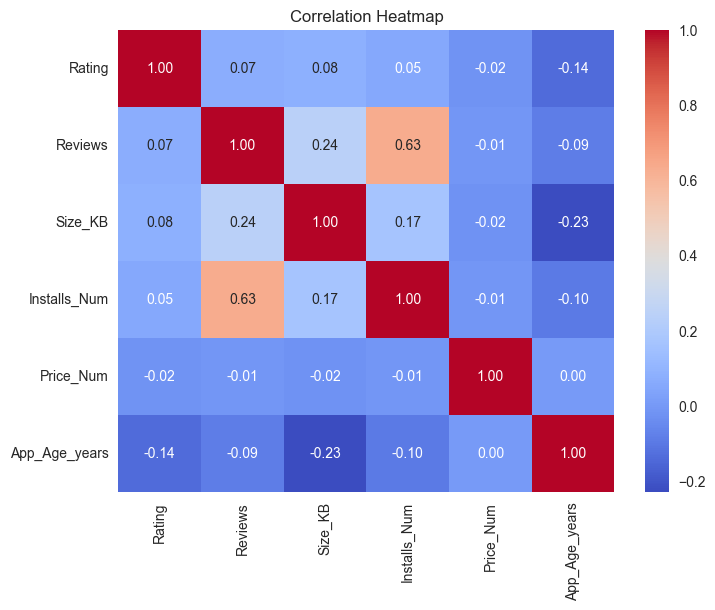

In [21]:

corr_features = ["Rating","Reviews","Size_KB","Installs_Num","Price_Num","App_Age_years"]
corr = df[corr_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


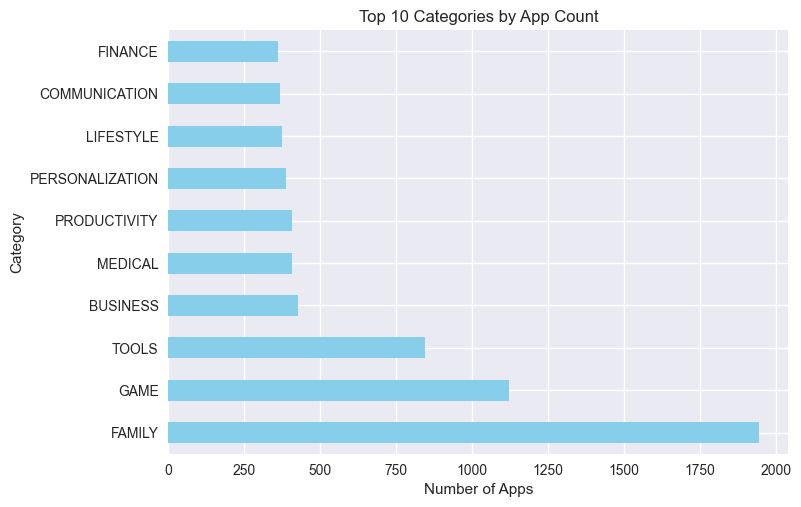

In [23]:

df["Category"].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Categories by App Count")
plt.xlabel("Number of Apps")
plt.show()


MAE: 0.365
RMSE: 0.547
R² Score: 0.135


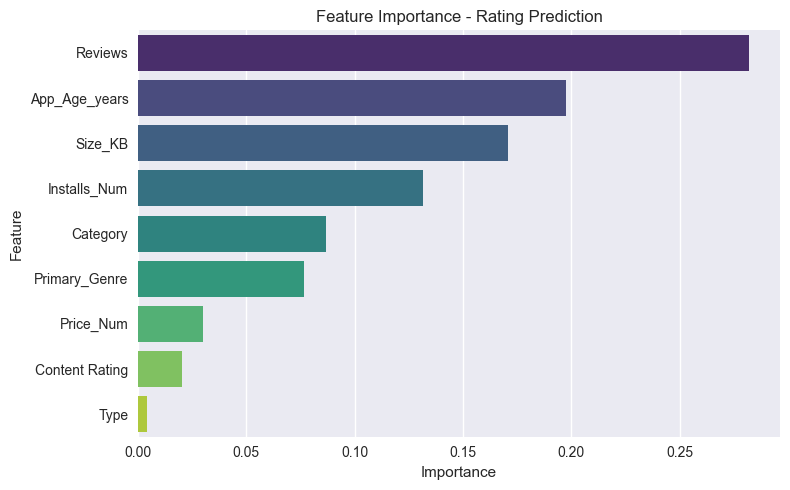

Model saved as playstore_rf_model.joblib


In [25]:
#machine Learning

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("googleplaystore_cleaned.csv")

df = df[df["Rating"].notna()]
features = ["Category", "Reviews", "Size_KB", "Installs_Num", "Price_Num", "App_Age_years", "Type", "Content Rating", "Primary_Genre"]
target = "Rating"

df = df[features + [target]].dropna()

le = LabelEncoder()
for col in ["Category", "Type", "Content Rating", "Primary_Genre"]:
    df[col] = le.fit_transform(df[col].astype(str))

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=12)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

importance = pd.DataFrame({"Feature": features, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=importance, palette="viridis")
plt.title("Feature Importance - Rating Prediction")
plt.tight_layout()
plt.show()

joblib.dump(rf, "playstore_rf_model.joblib")
print("Model saved as playstore_rf_model.joblib")
